# Importación de librerías

In [1]:
#Importación de librerías

import numpy as np
import matplotlib.pyplot as plt
from mne import io
import random
import scipy.signal as signal

# Lectura de archivo .edf

In [2]:
path01 = "epilepsy_detection/db/PN05-2.edf"

#Pongan el path completo porque no anda sino, yo dejo ese asi saben donde esta el .edf

raw01 = io.read_raw_edf(path01)

paciente = "PN05"

realizacion = "2"

Extracting EDF parameters from c:\Users\lucas\Documents\03-TPFINAL-PSIB\epilepsy_detection\epilepsy_detection\db\PN05-2.edf...
EDF file detected


FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\lucas\\Documents\\03-TPFINAL-PSIB\\epilepsy_detection\\epilepsy_detection\\db\\PN05-2.edf'

In [66]:
###########################################################################
# Organización de la información dentro del archivo .edf
###########################################################################

info = raw01.info

print(info)
print(info['ch_names'])

###########################################################################
# Obtención de las mediciones a utilizar y otros datos importantes
###########################################################################

# Se obtiene el nombre de todos los canales
ch_nms = info["ch_names"]

# Se obtienen los canales seleccionados del lazo izquierdo
#filt_ch_nms = ['EEG T3', 'EEG T5']
filt_ch_nms = ['EEG T3','EEG T5','EEG F7','EEG F3','EEG C3','EEG P3']

# Seleccionar los datos de los canales filtrados
raw01_filt = raw01.pick(filt_ch_nms)

# Obtener los datos de los canales filtrados por nombre
data_namefilt = raw01_filt.get_data()

# Se convierten las mediciones a microvoltios
data_namefilt = data_namefilt * 1e6

# Dimensiones de 'data_filt'
dim_data_filt = np.shape(data_namefilt)

# Verifición
print("Canales filtrados:", filt_ch_nms)
print(f"Cantidad de canales resultantes: {dim_data_filt[0]}")
print(f"Cantidad de datos en cada canal: {dim_data_filt[1]}")

<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fp1, EEG F3, EEG C3, EEG P3, EEG O1, EEG F7, EEG T3, EEG T5, ...
 chs: 37 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: 2016-01-01 06:46:02 UTC
 nchan: 37
 projs: []
 sfreq: 512.0 Hz
 subject_info: 1 item (dict)
>
['EEG Fp1', 'EEG F3', 'EEG C3', 'EEG P3', 'EEG O1', 'EEG F7', 'EEG T3', 'EEG T5', 'EEG Fc1', 'EEG Fc5', 'EEG Cp1', 'EEG Cp5', 'EEG F9', 'EEG Fz', 'EEG Cz', 'EEG Pz', 'EEG F4', 'EEG C4', 'EEG P4', 'EEG O2', 'EEG F8', 'EEG T4', 'EEG T6', 'EEG Fc2', 'EEG Fc6', 'EEG Cp2', 'EEG Cp6', 'EEG F10', 'EKG EKG', 'SPO2', 'HR', '1', '2', 'EEG FP2', 'EEG P9', 'EEG P10', 'MK']


Canales filtrados: ['EEG T3', 'EEG T5', 'EEG F7', 'EEG F3', 'EEG C3', 'EEG P3']
Cantidad de canales resultantes: 6
Cantidad de datos en cada canal: 4733440


In [67]:
###########################################################################
# Obtención de las mediciones a utilizar y otros datos importantes
###########################################################################

# Se obtiene el nombre de todos los canales
ch_nms = info["ch_names"]

# Se obtienen los canales seleccionados del lazo izquierdo
#filt_ch_nms = ['EEG T3', 'EEG T5']
filt_ch_nms = ['EEG T3','EEG T5','EEG F7','EEG F3','EEG C3','EEG P3']

# Seleccionar los datos de los canales filtrados
raw01_filt = raw01.pick(filt_ch_nms)

# Obtener los datos de los canales filtrados por nombre
data_namefilt = raw01_filt.get_data()

# Se convierten las mediciones a microvoltios
data_namefilt = data_namefilt * 1e6

# Dimensiones de 'data_filt'
dim_data_filt = np.shape(data_namefilt)

# Verifición
print("Canales filtrados:", filt_ch_nms)
print(f"Cantidad de canales resultantes: {dim_data_filt[0]}")
print(f"Cantidad de datos en cada canal: {dim_data_filt[1]}")

Canales filtrados: ['EEG T3', 'EEG T5', 'EEG F7', 'EEG F3', 'EEG C3', 'EEG P3']
Cantidad de canales resultantes: 6
Cantidad de datos en cada canal: 4733440


In [68]:
#Frecuencia de muestreo en Hz
fs = info["sfreq"]

#Cantidad de muestras tomadas
len_data = dim_data_filt[1]

#Array de instantes
start = 0
stop = (1/fs)*len_data
arr_t = np.arange(start=start,stop=stop,step=(1/fs))

# Verificación de datos
print("Frecuencia de muestreo:", fs)
print("Instantes [s]:", arr_t[0], "...", arr_t[-1])

Frecuencia de muestreo: 512.0
Instantes [s]: 0.0 ... 9244.998046875


# Definición de funciones

## Función para calcular instantes

In [69]:
#Función para calcular segundos a la hora 00.00.00
def time2seg(hora,minuto,segundo):
    seg1 = hora*3600
    seg2 = minuto*60
    seg3 = segundo

    seg = seg1+seg2+seg3

    return seg

## Función - Filtro FIR pasa-banda

In [239]:
def FIRfilterBP(arr_signals,freq=[1,100],order=(2**8)+1,fs=512):
    
    #0- Cálculo de los coeficientes del filtro FIR
    b_bp = signal.firwin(numtaps=order,cutoff=freq,window="blackman",pass_zero="bandpass",fs=fs)

    #1- Aplicación del filtro a las señales
    arr_filtered_signals = np.array([signal.filtfilt(b_bp, 1, sig) for sig in arr_signals])

    return arr_filtered_signals


## Función - Filtro IIR rechaza-banda

In [240]:
def IIRfilterBS(arr_signals,freq=[49.5,50.5],order=2,fs=512):
    
    #0- Cálculo de los coeficientes del filtro IIR
    b_bs, a_bs = signal.iirfilter(N=order,Wn=freq, btype="bandstop",ftype='butter', fs=fs)

    #1- Aplicación del filtro a las señales
    arr_filtered_signals = np.array([signal.filtfilt(b_bs, a_bs, sig) for sig in arr_signals])

    return arr_filtered_signals

## Análisis espectral por Welch

### Definición de las bandas

In [321]:
# Se definene las bandas de frecuencia

bandas = np.array([[0.5,4],
                  [4,8],
                  [8,13],
                  [13,30],
                  [30,50]])

### Función auxiliar 'closest' - Determina valor más proximo a otro

In [402]:
def closest(lst, K):
    return lst[min(range(len(lst)), key = lambda i: abs(K-lst[i]))]

### Función para calcular todas las potencias a partir de un único PSD

In [490]:
def pot4band(arr_freq, psd):
    
    #0- Definición de lista de almacenamiento
    arr_pot_abs4band = []
    
    #1- Cálculo de potencias absolutas y relativas para cada banda
    for banda in bandas:
        
        #2- Encontrar los índices de las frecuencias dentro de la banda de interés
        cercano_min = closest(arr_freq,banda[0])
        cercano_max = closest(arr_freq,banda[1])
        
        i_fmin = np.uint32([i for i in range(len(arr_freq)) if arr_freq[i] == cercano_min][0])
        i_fmax = np.uint32([i for i in range(len(arr_freq)) if arr_freq[i] == cercano_max][0])
    
        #3- Integrarla PSD dentro de la banda de frecuencia
        pot_abs_band = np.sum(psd[i_fmin:i_fmax]) * (arr_freq[1]-arr_freq[0])

        #4- Almacenamiento del valor de potencia calculado
        arr_pot_abs4band.append(pot_abs_band)
    
    #5- Preparación de arrays
    arr_pot_abs4band = np.array(arr_pot_abs4band)
    totalPow = np.sum(arr_pot_abs4band)
    arr_pot_rel4band = (100*arr_pot_abs4band)/totalPow
    
    #6- Concatenación de arrays
    arr_storage = np.array([totalPow])
    arr_storage = np.concatenate((arr_storage, arr_pot_abs4band))
    arr_storage = np.concatenate((arr_storage, arr_pot_rel4band))
    
    return arr_storage

### Función para calcular las potencias para un array de señales

In [535]:
def pot4signals(arr_signals,fs=512,divisor=100):

    #0- Cálculo del nper
    nper = int(len(arr_signals[0])//divisor)

    #1- Cálculo del array de PSDs para cada señal del array de señales
    arr_freq = signal.welch(x=arr_signals[0], fs=fs, noverlap=nper/2, nperseg=nper)[0]
    arr_psd = np.array([signal.welch(x=sig, fs=fs, noverlap=nper/2, nperseg=nper)[1] for sig in arr_signals])
    
    """plt.figure(figsize=(10, 4))
    plt.plot(np.arange(len(arr_signals[0])), arr_signals[0])
    plt.show()
    
    plt.figure(figsize=(10, 4))
    plt.plot(arr_freq, arr_psd[0])
    plt.xlim(left=0,right=50)
    plt.show()"""
    
    #2 Cálculo de potencias para cada señal del array de señales
    arr_pot4signals = np.array([pot4band(arr_freq,psd) for psd in arr_psd])
    
    return arr_pot4signals
    

## Función para obtener feature vectores + labels

In [549]:
def getMeData(signal,mtx_t_reg,arr_mtx_t_epi,winlen=2,fs=512,proportion=0.4):
    
    #0- Declaración de parámetros importantes
    step = fs*winlen
    
    ###########################################################################
    # PARTE 1 - Obtención de instante inicial y final
    ###########################################################################

    t_reg_start =   time2seg(mtx_t_reg[0][0],mtx_t_reg[0][1],mtx_t_reg[0][2])
    t_reg_end   =   time2seg(mtx_t_reg[1][0],mtx_t_reg[1][1],mtx_t_reg[1][2])
    
    ###########################################################################
    # PARTE 2 - Obtención de índices iniciales de intervalos verdaderos 
    ###########################################################################

    true_indexes = []
    for i in range(len(arr_mtx_t_epi)):
        
        #2.0- Obtención de instantes característicos del ataque epiléptico
        mtx_inst = arr_mtx_t_epi[i]

        t_epi_start =   time2seg(mtx_inst[0][0],mtx_inst[0][1],mtx_inst[0][2])-t_reg_start
        t_epi_end   =   time2seg(mtx_inst[1][0],mtx_inst[1][1],mtx_inst[1][2])-t_reg_start

        #2.1- Obtención de índice inicial del ataque epiléptico
        i_epi_start = fs*t_epi_start

        #2.2- Obtención de índices iniciales de cada segmento de longitud 'step'
        start = i_epi_start
        stop = step*((t_epi_end-t_epi_start)//winlen) + i_epi_start    
        interval = np.arange(start=start,stop=stop,step=step)
        
        #2.3- Concatenación del array de índices al array de índices iniciales de intervalos verdaderos
        true_indexes = np.uint32(np.concatenate((true_indexes, interval)))
     
     
    ###########################################################################
    # PARTE 3 - Obtención de índices iniciales de intervalos falsos 
    ###########################################################################
    
    false_indexes = []
    for i in range(len(arr_mtx_t_epi)+1):
        if i == 0:
            #3.0-  Obtención de instantes característicos del intervalo falso
            t_int_start = t_reg_start - t_reg_start
            t_int_end   = time2seg(arr_mtx_t_epi[0][0][0],arr_mtx_t_epi[0][0][1],arr_mtx_t_epi[0][0][2])-t_reg_start
            
        elif i == len(arr_mtx_t_epi):
            #3.0-  Obtención de instantes característicos del intervalo falso
            t_int_start = time2seg(arr_mtx_t_epi[i-1][1][0],arr_mtx_t_epi[i-1][1][1],arr_mtx_t_epi[i-1][1][2])-t_reg_start
            t_int_end   = t_reg_end - t_reg_start
            
        else:
            #3.0-  Obtención de instantes característicos del intervalo falso
            t_int_start = time2seg(arr_mtx_t_epi[i-1][1][0],arr_mtx_t_epi[i-1][1][1],arr_mtx_t_epi[i-1][1][2])-t_reg_start
            t_int_end   = time2seg(arr_mtx_t_epi[i][0][0],arr_mtx_t_epi[i][0][1],arr_mtx_t_epi[i][0][2])-t_reg_start
            
        #3.1- Obtención de índice inicial del intervalo falso
        i_int_start = fs*t_int_start
        
        #3.2- Obtención de índices iniciales de cada segmento de longitud 'step'
        start = i_int_start
        stop = step*((t_int_end-t_int_start)//winlen) + i_int_start    
        interval = np.arange(start=start,stop=stop,step=step)
        
        #3.3- Concatenación del array de índices al array de índices iniciales de intervalos falsos
        false_indexes = np.uint32(np.concatenate((false_indexes, interval)))
    
    
    ###########################################################################
    # PARTE 4 - Obtención de feature vectors y labels de elementos verdaderos 
    ###########################################################################
   
    #4.0- Obtención de array con los segmentos de señal verdaderos
    arr_seg_sig_true = np.array([signal[true_indexes[i]:(true_indexes[i]+step)] for i in range(len(true_indexes))])
    
    #4.1- Filtrado de los segmentos de la señal verdaderos
    arr_filtered_seg_sig_true = FIRfilterBP(arr_seg_sig_true)
    arr_filtered_seg_sig_true = IIRfilterBS(arr_filtered_seg_sig_true)
    
    #4.2- Potencias de los segmentos de la señal verdaderos
    arr_pot4segsig_true = pot4signals(arr_filtered_seg_sig_true,divisor=1)

    #4.OTROS FEATURES
    
    #4.FINAL-
    #fv_true = []
    fv_true = arr_pot4segsig_true
    labels_true = np.ones(len(true_indexes))
     
    ###########################################################################
    # PARTE 5 - Obtención de feature vectors y labels de elementos falsos
    ###########################################################################
    
    #5.0- Cálculo de cantidades características
    n_true_segments = len(true_indexes)
    k_false_segments = np.uint16(n_true_segments/proportion+1) - np.uint16(n_true_segments)
    
    #5.1- Obtención de 'k' indices no repetidos de intervalos falsos
    selected_false_indexes = random.sample(population=list(false_indexes),k=k_false_segments)

    #5.2- Obtención de array con los segmentos de la señal falsos
    arr_seg_sig_false = np.array([signal[selected_false_indexes[i]:(selected_false_indexes[i]+step)] for i in range(len(selected_false_indexes))])
    
    #5.3- Filtrado de los segmentos de la señal falsos
    arr_filtered_seg_sig_false = FIRfilterBP(arr_seg_sig_false)
    arr_filtered_seg_sig_false = IIRfilterBS(arr_filtered_seg_sig_false)
    
    #5.4- Potencias de los segmentos de la señal falsos
    arr_pot4segsig_false = pot4signals(arr_filtered_seg_sig_false,divisor=1)
    
    #5.OTROS FEATURES
    
    #5.FINAL-
    #fv_false = []
    fv_false = arr_pot4segsig_false
    labels_false = np.zeros(len(selected_false_indexes))
    
    ###########################################################################
    # PARTE 6 - Unión de arrays
    ###########################################################################
    
    arr_fv = np.concatenate((fv_false, fv_true))
    arr_labels = np.concatenate((labels_false, labels_true))
    
    return arr_fv, arr_labels
    
    

# Utilización de la función en una única señal

In [550]:
#Matriz de inicio de registro y final de registro
mtx_t_reg = np.array([[6,46,2],[9,19,47]])

#Array de matrices con instantes iniciales y finales de ataque epileptico
mtx_inst1 = np.array([[8,45,25],[8,46,0]])
arr_mtx_t_epi = np.array([mtx_inst1])

#Utilización de la función para una única señal
getMeData(signal=data_namefilt[0],mtx_t_reg=mtx_t_reg,arr_mtx_t_epi=arr_mtx_t_epi)

#Feature vector:
#[Pot total, potAbsDelta, potAbsTheta, potAbsAlpha, potAbsBeta, potAbsGamma, potRelDelta, potRelTheta, potRelAlpha, potRelBeta, potRelGamma]

(array([[7.83271667e+01, 5.68035051e+00, 9.66952678e+00, 2.65002171e+01,
         3.37900511e+01, 2.68702120e+00, 7.25208220e+00, 1.23450486e+01,
         3.38327278e+01, 4.31396315e+01, 3.43050989e+00],
        [3.15873782e+02, 2.12006967e+01, 4.70435100e+01, 1.10116665e+02,
         8.01910913e+01, 5.73218193e+01, 6.71176209e+00, 1.48931354e+01,
         3.48609701e+01, 2.53870678e+01, 1.81470646e+01],
        [2.84081422e+02, 9.61580397e+00, 2.60462510e+01, 9.37852014e+01,
         8.38071785e+01, 7.08269870e+01, 3.38487603e+00, 9.16858655e+00,
         3.30134934e+01, 2.95011120e+01, 2.49319320e+01],
        [5.15232096e+02, 3.48584861e+01, 9.03961069e+01, 1.18948849e+02,
         1.64307069e+02, 1.06721585e+02, 6.76558902e+00, 1.75447352e+01,
         2.30864596e+01, 3.18899133e+01, 2.07133029e+01],
        [1.23460989e+02, 1.06038576e+01, 1.45916747e+01, 5.57808858e+01,
         4.02407566e+01, 2.24381416e+00, 8.58883254e+00, 1.18188545e+01,
         4.51809809e+01, 3.25939043e+0

# NO ES IMPORTANTE - Solo para verificar correcto funcionamiento

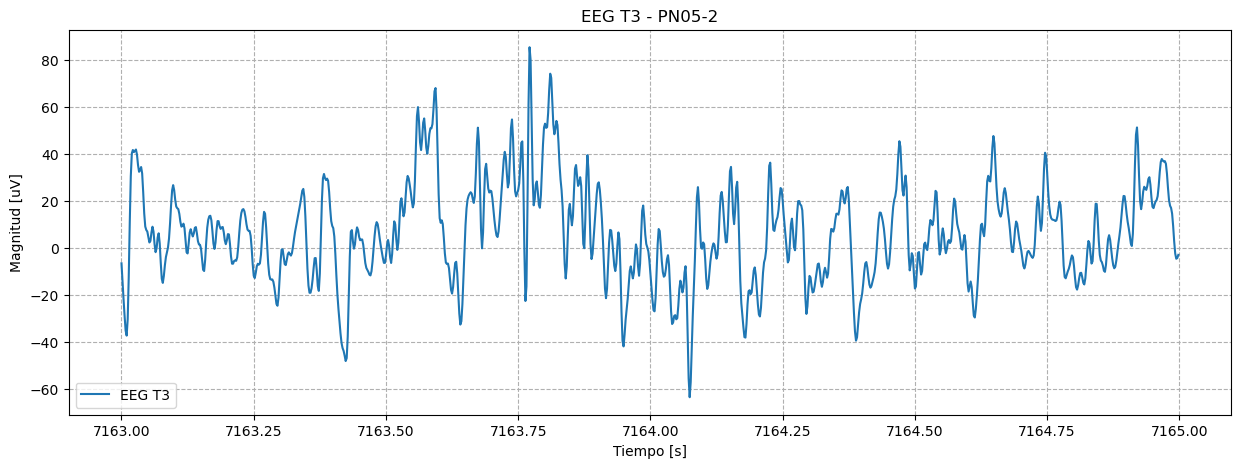

[[507.40392425 217.64423641  49.26900519  89.26362131  95.58034063
   55.6467207   42.89368411   9.71001658  17.59222131  18.83713075
   10.96694725]]


In [546]:
t_reg_start = time2seg(6,46,2)
t_epi_start = time2seg(8,45,25)-t_reg_start
t_epi_end = time2seg(8,46,0)-t_reg_start

epi_len = t_epi_end - t_epi_start

i_epi_start = 512*t_epi_start
i_epi_end = 512*t_epi_start + 1024

sig = np.array([data_namefilt[0][i_epi_start:i_epi_end]])
arr_filtered_seg_sig = FIRfilterBP(sig)
arr_filtered_seg_sig = IIRfilterBS(arr_filtered_seg_sig)

plt.figure(figsize=(15,5))
plt.plot(arr_t[i_epi_start:i_epi_end],arr_filtered_seg_sig[0],label="EEG T3")
plt.xlabel("Tiempo [s]")
plt.ylabel("Magnitud [uV]")
plt.title(f"{filt_ch_nms[0]} - {paciente}-{realizacion}")
plt.legend(loc="lower left")
plt.grid(linestyle="--")
plt.show()

arr = pot4signals(arr_filtered_seg_sig,divisor=1)

print(arr)
